<a href="https://colab.research.google.com/github/jaimeevers/electrodynamics/blob/master/Updated%2011_wave_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wave Equation

The electromagnetic fields in empty space obey a wave equation:
\begin{align*}
\dfrac{\partial^2 \vec{E}}{\partial t^2} - c^2 \nabla^2 \vec{E} &= 0 \\
\dfrac{\partial^2 \vec{B}}{\partial t^2} - c^2 \nabla^2 \vec{B} &= 0 \\
\end{align*}

The scalar and vector potentials in the Lorentz gauge obey an inhomogenous wave equation as well:
\begin{align*}
\dfrac{1}{c^2} \dfrac{\partial^2 \Phi}{\partial t^2} - \nabla^2 \Phi &= 4\pi \rho \\
\dfrac{1}{c^2} \dfrac{\partial^2 \vec{A}}{\partial t^2} - \nabla^2 \vec{A} &= \dfrac{4\pi}{c^2} \vec{J} \\
\end{align*}

This notebook will explore numerical methods for solving the wave equation.  We will explore specific examples in electrodynamics in the coming weeks.

The general form of the wave equation is
$$\dfrac{1}{c^2} \dfrac{\partial^2 \phi}{\partial t^2} - \nabla^2 \phi = 0$$

The simulation below includes a diffusion term, too.
$$\dfrac{1}{c^2} \dfrac{\partial^2 \phi}{\partial t^2} + \dfrac{1}{D} \dfrac{\partial \phi}{\partial t} - \nabla^2 \phi = 0$$

# Installation

In [1]:
from IPython import display

In [2]:
# Need to upgrade matplotlib for some PyVista plotting commands to work.
# Run this cell, then select "Runtime > Restart runtime" from the CoLab menu.
!pip install --upgrade matplotlib


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# This simulation uses real values.
try:
    import dolfinx
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-complex.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

In [4]:
# Everything should be installed now.
# Import the rest of what we need.
from dolfinx import fem, mesh, plot, la
import ufl

from mpi4py import MPI
import petsc4py.PETSc as petsc

import numpy as np
import pyvista

# Start a virtual plot window for PyVista in CoLab.
!sudo apt install libgl1-mesa-glx xvfb
!apt-get update
pyvista.start_xvfb()
pyvista.set_jupyter_backend("pythreejs")

# Get tools for embedding movies in CoLab.
from base64 import b64encode

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  xserver-common
Recommended packages:
  xfonts-base
The following NEW packages will be installed:
  libgl1-mesa-glx xvfb
The following packages will be upgraded:
  xserver-common
1 upgraded, 2 newly installed, 0 to remove and 14 not upgraded.
Need to get 817 kB of archives.
After this operation, 2,351 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libgl1-mesa-glx amd64 20.0.8-0ubuntu1~18.04.1 [5,532 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 xserver-common all 2:1.19.6-1ubuntu4.12 [27.0 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.12 [785 kB]
Fetched 817 kB in 1

In [5]:
if not np.issubdtype(petsc.ScalarType, np.complexfloating):
    print("This tutorial requires complex number support")
    sys.exit(0)
else:
    print(f"Using {petsc.ScalarType}.")

Using <class 'numpy.complex128'>.


# Real Time Simulation

One approach to studying the wave equation is to use a finite difference method.  We approximate the time derivative as follows:
$$
\dfrac{\partial^2 \phi}{\partial t^2}
\approx  
\dfrac{\phi_{n+1} - 2 \phi_{n} + \phi_{n-1}}{(\Delta t)^2}
$$
We then adapt the finite element problem to include a contribution from the two preceding time steps and solve for $\phi_{n+1}$ over and over.

Let's return to the potential from the previous notebook on the diffusion equation and observe the impact of a seemingly minor change in the code.

## Model

The model is a gaussian charge distribution inside of a box with grounded walls.

You can change the boundary conditions to explore other systems.

### Geometry

In [6]:
# Create a simple rectangular mesh.
length = 10
height = 10
Nx, Ny = 101, 101
extent = [[-length/2, -height/2], [length/2, height/2]]
domain = mesh.create_rectangle(
    MPI.COMM_WORLD, extent, [Nx, Ny], mesh.CellType.triangle)

In [7]:
# Prepare the mesh for plotting.
topology, cells, geometry = dolfinx.plot.create_vtk_mesh(domain)

# Turn the mesh into a PyVista grid.
grid = pyvista.UnstructuredGrid(topology, cells, geometry)

# Create the plot and export it to HTML.
plotter = pyvista.Plotter(window_size=(800, 400))
renderer = plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()

# Save the HTML file.
plotter.export_html("./grid.html", backend="pythreejs")

# Use the IPython library to embed the HTML in the CoLab notebook.
display.HTML(filename='/content/grid.html')

### Charge Density

This time, we will define the charge density as a time-dependent function on the grid.

In [8]:
# Define a set of functions on our mesh.
V = dolfinx.fem.FunctionSpace(domain, ("Lagrange", 2))
# V = dolfinx.fem.FunctionSpace(domain, ("CG", 1))

In [9]:
# Define the charge.
xC = -1
yC = -1
Q = 1
sQ = 0.2
beta = 1/sQ
tau = 1

# This function returns a function that can be interpolated.
def rho_function(t):
    return lambda x: Q * beta / 2 / np.pi * np.exp(-t/tau) * np.exp(-0.5 * beta**2 * ((x[0]-xC)**2 + (x[1] - yC)**2))

# Turn this function definition into a time-dependent function on the mesh.
rho = fem.Function(V)

# Initialize the function for t=0.
rho.interpolate(rho_function(0))

In [10]:
# Plot the initial charge density.
topology, cells, geometry = plot.create_vtk_mesh(rho.function_space)
grid = pyvista.UnstructuredGrid(topology, cells, geometry)
grid.point_data["rho"] = rho.x.array.real
grid.set_active_scalars("rho")

# The grid is flat.  This will warp the grid into three dimensions
# using the value of the function as the height.
warped = grid.warp_by_scalar("rho", factor=10)

# Create the plot and export it to HTML.
plotter = pyvista.Plotter(window_size=(800, 400))
renderer = plotter.add_mesh(
    warped,
    lighting=False,
    show_edges=False,
    scalar_bar_args={"title": "Charge Density"},
    clim=[0, 1],
    cmap='turbo'
)
plotter.add_text("Initial Charge Density")
# Save the HTML file.
plotter.export_html("./rho-initial.html", backend="pythreejs")

# Use the IPython library to embed the HTML in the CoLab notebook.
display.HTML(filename='/content/rho-initial.html')

### Boundary Conditions

We will set the potential to zero on the boundary to compute the initial potential and fields.  After this, the boundaries will be open.

In [11]:
# Define a function to locate boundaries.
# It will return True for points on the boundary, and False otherwise.
def find_facets(x):
    yes = np.isclose(x[0], -length/2)
    yes += np.isclose(x[0], length/2)
    yes += np.isclose(x[1], -height/2)
    yes += np.isclose(x[1], height/2)
    return yes

# Next, we use this function to tag each cell along the boundary.
tdim = domain.topology.dim
bc_facets = mesh.locate_entities_boundary(
    domain, tdim - 1, find_facets)

# Identify those for which the function was True as
# boundary_dofs = "boundary degrees of freedom"
boundary_dofs = fem.locate_dofs_topological(V, tdim - 1, bc_facets)

# # Now introduce the boundary condition: constant potential on the boundary.
# Define the potential on the boundary.
def uD_function(t):
    return lambda x: 0j * x[0]

# Turn this function definition into a time-dependent function on the mesh.
uD = fem.Function(V)

# Initialize the function for t=0.
uD.interpolate(uD_function(0.0))

# Add these to the list of boundary conditions to be imposed.
# This will apply the uD function to the cells along the boundary.
# It will be updated during each time step.
bcs = [fem.dirichletbc(uD, boundary_dofs)]

### Initial Potential

In [12]:
# Define the trial and test functions.
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# Create a function to store the solution.
phi = fem.Function(V)
phi_n = fem.Function(V)

# This is the FEM version of the Laplacian.
# It is the left-hand side of Poisson's equation.
a = ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx

# This is how we introduce the charge density.
# It is the right-hand side of Poisson's equation.
L = 4 * ufl.pi * ufl.inner(rho,v) * ufl.dx

# Put it all together for FEniCSx.
problem = fem.petsc.LinearProblem(a, L, bcs=bcs, u=phi, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})

# Now, solve it!
problem.solve()

# Tie up some loose ends.
phi.vector.ghostUpdate(addv=petsc.InsertMode.INSERT, mode=petsc.ScatterMode.FORWARD)

display.clear_output()

In [13]:
# Plot the initial potential.
topology, cells, geometry = plot.create_vtk_mesh(rho.function_space)
grid = pyvista.UnstructuredGrid(topology, cells, geometry)
grid.point_data["phi"] = phi.x.array.real
grid.set_active_scalars("phi")

# The grid is flat.  This will warp the grid into three dimensions
# using the value of the function as the height.
warped = grid.warp_by_scalar("phi", factor=10)

# Create the plot and export it to HTML.
plotter = pyvista.Plotter(window_size=(800, 400))
renderer = plotter.add_mesh(
    warped,
    lighting=False,
    show_edges=False,
    scalar_bar_args={"title": "Potential"},
    clim=[0, 1],
    cmap='turbo'
)
plotter.add_text("Initial Potential")
# Save the HTML file.
plotter.export_html("./phi-initial.html", backend="pythreejs")

# Use the IPython library to embed the HTML in the CoLab notebook.
display.HTML(filename='/content/phi-initial.html')

In [14]:
# Store this solution for reuse later.
phi_initial = phi.copy()

## Time Evolution

Let's compare the diffusion and wave equations side by side.

In [36]:
# Initial time and maximum time.
t0 = 0.0
t_max = 0.05
t_step = 0.002

# Wave speed.
c_val = 500.0

# Diffusion constant.
d_val = 200.0

# This is the time step for the simulation.
c = fem.Constant(domain, petsc.ScalarType(c_val))
D = fem.Constant(domain, petsc.ScalarType(d_val))
dt = fem.Constant(domain, petsc.ScalarType(t_step))
f = fem.Constant(domain, petsc.ScalarType(0.0))

### Diffusion

In [37]:
# Reset the initial potential.
phi = phi_initial.copy()
phi_n = fem.Function(V)

In [38]:
# This is the problem we are going to solve:
# The diffusion equaiton, in weak form for finite elements.
F = ufl.inner(u - phi_n, v) * ufl.dx
F += dt * D * ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
F -= dt * rho * ufl.conj(v) * ufl.dx
(a, L) = ufl.system(F)

In [39]:
## Choose boundary conditions.
bcs = [fem.dirichletbc(uD, boundary_dofs)]
# bcs = []

In [40]:
# Building the matrix for the finite element problem takes a while.
# It does not change throughout the problem, either.  The following
# line build the matrix once and store it for reuse.
compiled_a = fem.form(a)
A = fem.petsc.assemble_matrix(compiled_a, bcs=bcs)
A.assemble()

display.clear_output()

In [41]:
# We do the same for the vector, but it will be updated at each time step.
compiled_L = fem.form(L)
b = fem.Function(V)

display.clear_output()

In [42]:
# Now we use the PETSc problem to construct the linear algebra problem.
solver = petsc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(petsc.KSP.Type.CG)
pc = solver.getPC()
pc.setType(petsc.PC.Type.LU)

In [43]:
# Set potential to initial solution.
phi = phi_initial.copy()

# Create a plotter for charge density, but don't display the plot.
phi_file = "%03d-diffusion.jpg"

# It will be making a movie in the background.
phi_plotter = pyvista.Plotter(notebook=False, off_screen=True)

# And add the charge and potentials to the plot.
topology, cells, geometry = plot.create_vtk_mesh(phi.function_space)
phi_grid = pyvista.UnstructuredGrid(topology, cells, geometry)
phi_grid.point_data["phi"] = phi.x.array.real
phi_grid.set_active_scalars("phi")

# The grid is flat.  This will warp the grid into three dimensions
# using the value of the function as the height.
phi_warped = phi_grid.warp_by_scalar("phi", factor=10)

# Add the warped grid to the plot.
phi_plotter.add_mesh(
    phi_warped,
    lighting=False,
    show_edges=False,
    clim=[0, 1],
    cmap='turbo'
);

In [44]:
# Get rid of old diffusion movie files.
!rm *-diffusion.jpg
!rm diffusion-movie.mp4

In [45]:
# Now, compute an update for each time step and add it to the movie.
# Initial time
t = t0
n = 0

# Set up the initial potential.
phi = phi_initial.copy()
phi_n.x.array[:] = phi_initial.x.array

# Loop until completion.
while t < t_max:
    # Take snapshots for the video.
    phi_frame = phi_file % n
    phi_plotter.show(screenshot=phi_frame, auto_close=False) 
    
    # Update boundary conditions.
    t += dt.value
    rho.interpolate(rho_function(t))
    uD.interpolate(uD_function(t))

    # Assemble the RSH: the vector on the "right-hand side" of A.u = b.
    b.x.array[:] = 0
    fem.petsc.assemble_vector(b.vector, compiled_L)

    # Apply boundary condition.
    # These commands distribute the updated problem to all processes.
    fem.petsc.apply_lifting(b.vector, [compiled_a], [bcs])
    b.x.scatter_reverse(la.ScatterMode.add)
    fem.petsc.set_bc(b.vector, bcs)

    # Solve linear problem.
    solver.solve(b.vector, phi.vector)

    # Distribute the solution to all processes.
    phi.x.scatter_forward()

    # Update un --- the current value of the function.
    phi_n.x.array[:] = phi.x.array

    # Update the plots and save the frame.
    phi_grid.point_data["phi"] = phi.x.array.real
    phi_warped = phi_grid.warp_by_scalar("phi", factor=10)
    phi_plotter.update_scalars(phi.x.array.real, render=False)
    phi_plotter.update_coordinates(phi_warped.points, render=False)

    n += 1

# Take final snapshots for the video.
phi_frame = phi_file % n
phi_plotter.show(screenshot=phi_frame, auto_close=False)

# Close the plotter and finish processing the movie.
phi_plotter.close()

display.clear_output()

In [46]:
!ffmpeg -y -i %03d-diffusion.jpg -pix_fmt yuv420p diffusion-movie.mp4

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

### Wave Equation

In [47]:
# Reset the initial potential.
phi = phi_initial.copy()
phi_n = fem.Function(V)
phi_n_1 = fem.Function(V)

In [48]:
# This is the problem we are going to solve:
# The wave equaiton, in weak form for finite elements.
u_n = 0.25*u + 0.5*phi_n + 0.25*phi_n_1
F = ufl.inner(u - 2*phi_n + phi_n_1, v) * ufl.dx
F += dt**2 * c**2 * ufl.inner(ufl.grad(u_n), ufl.grad(v)) * ufl.dx

# Add a diffusive term to keep the solution from blowing up right away.
F += c**2 * dt / D * ufl.inner(u - phi_n, v) * ufl.dx

# Add a potential source term.
F -= dt**2 * c**2 * ufl.inner(f, v) * ufl.dx

# Assemble the FEM problem.
(a, L) = ufl.system(F)

display.clear_output()

In [49]:
## Choose boundary conditions.
bcs = [fem.dirichletbc(uD, boundary_dofs)]
# bcs = []

In [50]:
# Building the matrix for the finite element problem takes a while.
# It does not change throughout the problem, either.  The following
# line build the matrix once and store it for reuse.
compiled_a = fem.form(a)
A = fem.petsc.assemble_matrix(compiled_a, bcs=bcs)
A.assemble()

display.clear_output()

In [51]:
# We do the same for the vector, but it will be updated at each time step.
compiled_L = fem.form(L)
b = fem.Function(V)

display.clear_output()

In [52]:
# Now we use the PETSc problem to construct the linear algebra problem.
solver = petsc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(petsc.KSP.Type.CG)
pc = solver.getPC()
pc.setType(petsc.PC.Type.LU)

In [53]:
# Set potential to initial solution.
phi = phi_initial.copy()

# Create a plotter for charge density, but don't display the plot.
phi_file = "%03d-wave.jpg"

# It will be making a movie in the background.
phi_plotter = pyvista.Plotter(notebook=False, off_screen=True)

# And add the charge and potentials to the plot.
topology, cells, geometry = plot.create_vtk_mesh(phi.function_space)
phi_grid = pyvista.UnstructuredGrid(topology, cells, geometry)
phi_grid.point_data["phi"] = phi.x.array.real
phi_grid.set_active_scalars("phi")

# The grid is flat.  This will warp the grid into three dimensions
# using the value of the function as the height.
phi_warped = phi_grid.warp_by_scalar("phi", factor=10)

# Add the warped grid to the plot.
phi_plotter.add_mesh(
    phi_warped,
    lighting=False,
    show_edges=False,
    clim=[0, 1],
    cmap='turbo'
);

In [54]:
# Get rid of old diffusion movie files.
!rm *-wave.jpg
!rm wave-movie.mp4

In [55]:
# Now, compute an update for each time step and add it to the movie.
# Initial time
t = t0
n = 0

# Set up the initial potential.
phi = phi_initial.copy()
phi_n_1.x.array[:] = phi_initial.x.array
phi_n.x.array[:] = phi_initial.x.array


# Loop until completion.
while t < t_max:
    # Take snapshots for the video.
    phi_frame = phi_file % n
    phi_plotter.show(screenshot=phi_frame, auto_close=False) 
    
    # Update boundary conditions.
    t += dt.value
    rho.interpolate(rho_function(t))
    uD.interpolate(uD_function(t))

    # Assemble the RSH: the vector on the "right-hand side" of A.u = b.
    b.x.array[:] = 0
    fem.petsc.assemble_vector(b.vector, compiled_L)

    # Apply boundary condition.
    # These commands distribute the updated problem to all processes.
    fem.petsc.apply_lifting(b.vector, [compiled_a], [bcs])
    b.x.scatter_reverse(la.ScatterMode.add)
    fem.petsc.set_bc(b.vector, bcs)

    # Solve linear problem.
    solver.solve(b.vector, phi.vector)

    # Distribute the solution to all processes.
    phi.x.scatter_forward()

    # Update un --- the current value of the function.
    phi_n.x.array[:] = phi.x.array.real

    # Update the plots and save the frame.
    phi_grid.point_data["phi"] = phi.x.array.real
    phi_warped = phi_grid.warp_by_scalar("phi", factor=10)
    phi_plotter.update_scalars(phi.x.array.real, render=False)
    phi_plotter.update_coordinates(phi_warped.points, render=False)

    n += 1

# Take final snapshots for the video.
phi_frame = phi_file % n
phi_plotter.show(screenshot=phi_frame, auto_close=False)

# Close the plotter and finish processing the movie.
phi_plotter.close()

display.clear_output()

In [56]:
!ffmpeg -y -i %03d-wave.jpg -pix_fmt yuv420p wave-movie.mp4

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

## Results

In [57]:
## Play the diffusion movie.
mp4 = open('diffusion-movie.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
display.HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [59]:
# Play the wave movie.
mp4 = open('wave-movie.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
display.HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## Questions

Compare and contrast the two simulations.  Use the slider of the movie to view the action frame by frame.

- Describe similarities and differences between the diffusion simulation and the wave simulation.

***Describe your observations below.***

Relaxation was much faster with the wave equation than with the diffusion equation. Additionally, the wave was clear by the fact that the plot inverted and came back repeatedly, showing the form of a wave (when lokoing frame by frame). This makes sense because there is always a back and forth transfer before any equilibrium is met. The video is somewhat broken, especially near the end, because equilibrium is never met.

# Helmholtz Equation

You probably noticed that the wave equation does not look right after a few frames.  This is due to ***numerical instability*** in the simulation.  Effects at the boundaries and processes that would take place "inside" one of our mesh cells or "between" our discrete time steps eventually cause the wave simulation to "blow up".

It's fun to watch, but it's not representative of what happens in a real system — most of the time.

There are techniques for dealing with this instability, but there are other ways to study the dynamics of waves, too.  A very important method is "plane wave decomposition" — a kind of Fourier analysis, where we study the behavior of waves of a single frequency.

We use separation of variables:
$$\phi(\vec{r},t) = \phi(\vec{r}) \, e^{-i\omega t}$$

In empty space, or in a uniform material, the spatial part of our solution can also be represented by a plane wave:
$$
\phi(\vec{r}) = A e^{i\vec{k} \cdot \vec{r}}
\qquad \implies \qquad
\phi(\vec{r},t) = A e^{i(\vec{k}\cdot\vec{r} - \omega t)}
$$
However, when the material is not uniform — an interface, an obstacle, an impurity — plane waves scatter.  The frequency does not change, but $\phi(\vec{r})$ can no longer be represented by a single wave vector $\vec{k}$.  We can still simplify the problem we have to solve, though.  If we substitute $\phi(\vec{r}) \, e^{-i\omega t}$ into the (generalized) wave equation, we find
\begin{align*}
0 &= \dfrac{1}{c^2} \dfrac{\partial^2 \phi}{\partial t^2} + \dfrac{1}{D} \dfrac{\partial \phi}{\partial t} - \nabla^2 \phi \\
&= \left(-\dfrac{\omega^2}{c^2} \phi(\vec{r})
- \dfrac{i\omega}{D} \phi(\vec{r}) - \nabla^2 \phi(\vec{r})\right)
e^{-i\omega t} \\
0 &= \nabla^2 \phi(\vec{r}) + \dfrac{\omega^2}{c^2} \phi(\vec{r})
+ \dfrac{i\omega}{D} \phi(\vec{r}) 
\end{align*}

This may not look like an improvement, but we now have a ***time-independent*** PDE for $\phi(\vec{r})$, which we can solve ***once*** to learn about the ***time-dependent*** behavior for ***all*** times!

This equation is similar to Laplace's equation and Poisson's equation, but not the same.  It is called ***the Helmholtz equation.***



## Model

Our original model of the "disappearing charge distribution" is not described by a single plane wave.

We will construct a new model instead: a plane wave that collides with an object that has a different index of refraction — hence, a different wave speed — than the surrounding medium.

In [239]:
# Set the frequency of the wave.
omega = 2 * np.pi

# Set the background index of refraction.
n0 = 1.0

# Set the maximum index of refraction inside the obstacle.
n_max = 2.0

# Set the size of the scattering object.
spread = .5

# Set the wave speed.
c = 1.0

# Compute the wave vector.
k0 = n0 * omega / c

## Geometry

In [240]:
# Use the same grid.
# Create a simple rectangular mesh.
length = 10
height = 10
Nx, Ny = 51, 51
extent = [[-length/2, -height/2], [length/2, height/2]]
domain = mesh.create_rectangle(
    MPI.COMM_WORLD, extent, [Nx, Ny], mesh.CellType.triangle)

In [241]:
# Prepare the mesh for plotting.
topology, cells, geometry = dolfinx.plot.create_vtk_mesh(domain)

# Turn the mesh into a PyVista grid.
grid = pyvista.UnstructuredGrid(topology, cells, geometry)

# Create the plot and export it to HTML.
plotter = pyvista.Plotter(window_size=(800, 400))
renderer = plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()

# Save the HTML file.
plotter.export_html("./grid.html", backend="pythreejs")

# Use the IPython library to embed the HTML in the CoLab notebook.
display.HTML(filename='/content/grid.html')

## Obstacle

Add a dielectric object to the center of the region.  We'll describe it by a gaussian function.  You can picture it as concentric shells of decreasing dielectric strength.

In [285]:
# Define a set of functions on our mesh.
V = dolfinx.fem.FunctionSpace(domain, ("Lagrange", 2))

In [300]:
# Define the obstacle.
xC = 0
yC = -1
beta = 1/spread

# This function returns a function that can be interpolated.
def n_function(x0,y0):
    # return lambda x: n0 + (n_max - n_0) * np.exp(-0.5 * beta**2 * ((x[0]-x0)**2 + (x[1] - y0)**2))
    return lambda x: n0 + \
    (n_max - n0) * np.exp(-0.5 * beta**2 * ((x[0]-x0)**2 + (x[1] + y0)**2)) + \
    (n_max - n0) * np.exp(-0.5 * beta**2 * ((x[0]-x0)**2 + (x[1] - y0)**2))

# Turn this function definition into a time-dependent function on the mesh.
index = fem.Function(V)

# Initialize the function for t=0.
# index.interpolate(n_function(xC,yC))
index.interpolate(n_function(xC,2))

In [314]:
# Define the obstacle.
xD = 0
yD = 1
beta = 1/spread

# This function returns a function that can be interpolated.
def n_function(x0,y0):
    # return lambda x: n0 + (n_max - n_0) * np.exp(-0.5 * beta**2 * ((x[0]-x0)**2 + (x[1] - y0)**2))
    return lambda x: n0 + \
    (n_max - n0) * np.exp(-0.5 * beta**2 * ((x[0]-x0)**2 + (x[1] + y0)**2)) + \
    (n_max - n0) * np.exp(-0.5 * beta**2 * ((x[0]-x0)**2 + (x[1] - y0)**2))

# Turn this function definition into a time-dependent function on the mesh.
index = fem.Function(V)

# Initialize the function for t=0.
# index.interpolate(n_function(xC,yC))
index.interpolate(n_function(xD,2))

In [315]:
# Plot the index of refraction.
topology, cells, geometry = plot.create_vtk_mesh(index.function_space)
grid = pyvista.UnstructuredGrid(topology, cells, geometry)
grid.point_data["n"] = index.x.array.real
grid.set_active_scalars("n")

# The grid is flat.  This will warp the grid into three dimensions
# using the value of the function as the height.
warped = grid.warp_by_scalar("n", factor=10)

# Create the plot and export it to HTML.
plotter = pyvista.Plotter(window_size=(800, 400))
renderer = plotter.add_mesh(
    warped,
    lighting=False,
    show_edges=False,
    scalar_bar_args={"title": "Index of refraction"},
    clim=[n0, n_max],
    cmap='turbo'
)
plotter.add_text("Index of Refraction")
# Save the HTML file.
plotter.export_html("./index.html", backend="pythreejs")

# Use the IPython library to embed the HTML in the CoLab notebook.
display.HTML(filename='/content/index.html')

## Boundary Conditions

The boundary conditions are quite different here.  We want a plane wave incident from the left (moving to the right).  We will fix the boundary conditions to represent this plane wave.  The other boundaries will be natural (open).

We need to match the value and the normal derivative of the incoming wave at the edges of the mesh.  To do this, we add a boundary term to the finite element problem:
$$\hat{n}\cdot\nabla u + in \dfrac{\omega}{c} u = \hat{n}\cdot\nabla\phi_{0} + in \dfrac{\omega}{c} \phi_{0}$$

In [303]:
n_hat = ufl.FacetNormal(domain)
x = ufl.SpatialCoordinate(domain)
phi0 = ufl.exp(1j * k0 * x[0])
g = ufl.dot(ufl.grad(phi0), n_hat) + 1j * k0 * phi0

display.clear_output()

## Finite Element Problem

In [316]:
# Define the trial and test functions.
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# Create a function to store the solution.
phi = fem.Function(V)

# This is the FEM version of the Helmholtz equation.
# It includes a boundary term, indicated by "ds".
a = - ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx \
    + index**2 * k0**2 * ufl.inner(u, v) * ufl.dx \
    + 1j * k0 * ufl.inner(u, v) * ufl.ds

# This is the boundary condition.
L = ufl.inner(g, v) * ufl.ds

# Put it all together for FEniCSx.
problem = fem.petsc.LinearProblem(a, L, u=phi, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})

# Now, solve it!
problem.solve()

# Tie up some loose ends.
phi.vector.ghostUpdate(addv=petsc.InsertMode.INSERT, mode=petsc.ScatterMode.FORWARD)

display.clear_output()

### Time Evolution

We can now simulate time evolution.  The spatial part of our solution does not change in time.  We need to multiply it by $e^{-i\omega t}$ and plot the real part as $t$ advances.

In [317]:
# Prepare the mesh for PyVista ...
topology, cells, geometry = plot.create_vtk_mesh(V)

# Create a plotter for charge density, but don't display the plot.
phi_file = "%03d-helmholtz.jpg"

# It will be making a movie in the background.
phi_plotter = pyvista.Plotter(notebook=False, off_screen=True)

# And add the charge and potentials to the plot.
topology, cells, geometry = plot.create_vtk_mesh(phi.function_space)
phi_grid = pyvista.UnstructuredGrid(topology, cells, geometry)
phi_grid.point_data["phi"] = phi.x.array.real
phi_grid.set_active_scalars("phi")

# The grid is flat.  This will warp the grid into three dimensions
# using the value of the function as the height.
phi_warped = phi_grid.warp_by_scalar("phi", factor=0.2)

# Add the warped grid to the plot.
phi_plotter.add_mesh(
    phi_warped,
    lighting=False,
    show_edges=False,
    clim=[-2, 2],
    cmap='plasma'
);

In [318]:
# Get rid of any old movie files.
!rm *-helmholtz.jpg
!rm helmholtz-movie.mp4

In [319]:
# Now, compute an update for each time step and add it to the movie.
# Initial time
t = 0.0
T = 2*np.pi / omega
t_max = 4 * T
dt = T / 60

n = 0

# Loop until completion.
while t < t_max:
    # Take snapshots for the video.
    phi_frame = phi_file % n
    phi_plotter.show(screenshot=phi_frame, auto_close=False) 
    
    # Update boundary conditions.
    t += dt
    
    # Update the plot and save the frame.
    phi_real = np.real(phi.x.array * np.exp(-1j * omega * t))
    phi_grid.point_data["phi"] = phi_real
    phi_warped = phi_grid.warp_by_scalar("phi", factor=0.2)
    phi_plotter.update_scalars(phi_real, render=False)
    phi_plotter.update_coordinates(phi_warped.points, render=False)
    phi_frame = phi_file % n

    n += 1

# Take final snapshots for the video.
phi_frame = phi_file % n
phi_plotter.show(screenshot=phi_frame, auto_close=False)

# Close the plotter and finish processing the movie.
phi_plotter.close()

In [320]:
# Assemble the movies with FFMPEG.
!ffmpeg -y -i %03d-helmholtz.jpg -pix_fmt yuv420p helmholtz-movie.mp4

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

## Results

Let look at the results.

In [321]:
# See the results.
topology, cells, geometry = plot.create_vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cells, geometry)
grid.point_data["phi_R"] = phi.x.array.real
grid.point_data["phi_I"] = phi.x.array.imag
grid.point_data["phi_0"] = np.abs(phi.x.array)

In [322]:
# Plot the real part.
grid.set_active_scalars("phi_R")
warped = grid.warp_by_scalar("phi_R", factor=0.1)

# Create the plot and export it to HTML.
plotter = pyvista.Plotter(window_size=(800, 400))
renderer = plotter.add_mesh(
    warped,
    lighting=False,
    show_edges=False,
    scalar_bar_args={"title": "Potential"},
    clim=[-2, 2],
    cmap='plasma'
)
plotter.add_text("Real Part")
# Save the HTML file.
plotter.export_html("./phi-real.html", backend="pythreejs")

# Use the IPython library to embed the HTML in the CoLab notebook.
display.HTML(filename='/content/phi-real.html')

In [323]:
# Plot the imaginary part.
grid.set_active_scalars("phi_I")
warped = grid.warp_by_scalar("phi_I", factor=0.1)

# Create the plot and export it to HTML.
plotter = pyvista.Plotter(window_size=(800, 400))
renderer = plotter.add_mesh(
    warped,
    lighting=False,
    show_edges=False,
    scalar_bar_args={"title": "Potential"},
    clim=[-2, 2],
    cmap='plasma'
)
plotter.add_text("Real Part")
# Save the HTML file.
plotter.export_html("./phi-imag.html", backend="pythreejs")

# Use the IPython library to embed the HTML in the CoLab notebook.
display.HTML(filename='/content/phi-imag.html')

In [324]:
# Plot the modulus.
grid.set_active_scalars("phi_0")
warped = grid.warp_by_scalar("phi_0", factor=0.1)

# Create the plot and export it to HTML.
plotter = pyvista.Plotter(window_size=(800, 400))
renderer = plotter.add_mesh(
    warped,
    lighting=False,
    show_edges=False,
    scalar_bar_args={"title": "Potential"},
    clim=[0, 2],
    cmap='plasma'
)
plotter.add_text("Real Part")
# Save the HTML file.
plotter.export_html("./phi-abs.html", backend="pythreejs")

# Use the IPython library to embed the HTML in the CoLab notebook.
display.HTML(filename='/content/phi-abs.html')

In [325]:
# Play the potential movie.
mp4 = open('helmholtz-movie.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
display.HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## Questions

Run the cells in the Helmholtz section of this notebook.  Inspect the plots and video that result.


### Plane wave

The index of refraction is constant on the entire mesh.

- Describe the plots you see.  What does the plane wave do in this case?
- Is the output consistent with what you expect?  Explain why or why not.

***Type your response below.***

Overall, these plots are  closer to what I'd expect at the edges. The main difference I noticed between the real and imaginary plots was that at the boundaries/edges, the imaginary plot flattens out, losing th ewave shape, but the real values plot shows a uniform wave shape along the edges. Watching the video, I noticed there is a wave motion from left to right, but also a maintained wave shape from front to back of the plot. It looks like the imaginary values happen when the wave ends are at a node, whereas the real values happen when the edges are at antibodes. I was surprised that the edges flatten out while the rest of the sheet/plot follows the wave pattern.

### Adjust the frequency

Go to the "Model" section above (in the "Helmholtz Equation" section of the notebook).  You can change the frequency of the wave by adjusting $\omega$ — the `omega` variable.

- What do you expect to happen if you increase $\omega$?  If you decrease $\omega$?
- Double the value of $\omega$ or reduce it by half.  What happens in the plots and video?

***Include your predictions and observations below.***


**Predictions**
 - I expect decreasing frequency to "stretch out" the plots, creating a larger wavelength, and I expect the opposite when increasing the frequency. I also expect a change at the edges (and therefore eral vs imaginary) but I'm not sure what.

**Observations**
  - When setting ω = 4 (doubling it), the plots got super squished; there was double the number of waves, because wavelength was halved. The movie didn't change, but I think that's a problem with something I did, not a representation of what actually happens... the differences b/w imaginary vs real did not change either
  - Setting ω = 1 (halving it) was about what I expected - the waves were way stretched out and fatter (longer wavelength). Again, i vs R didn't change, but the movie did change ths time, and it became way easier to see what was happening. It looks like the waves/changes are happening at the boundaries, and the rest of the plot is following behind, but I'm not sure what this means

### Introduce an obstacle

You can introduce an obstacle by changing the value of `n_max`.  This will introduce a round region of higher index of refraction in the center of the box.

- What do you expect to happen if you introduce such an obstacle?
- Set `n_max = 2.0`.  Describe what happens.

***Include your predictions and observations below.***

**predictions**
 - I expect a higher n in the middle will cause a significant change in the plot. With some reflection and refraction, the wave pattern after the obstacle will be smaller and in a different direction
**observations**
 - changing n_max = 2

**observations**
 - The wave amplitude or wavelength didn't seem to be different after the obstacle, but the pattern and direction were completely distured. One cool thing looking at the real plot was that there was a half-circle pattern around where the edge of the obstacle would be, but the way it influenced the wave also caused a matching half circle on both sides. 
 - There done seem to be reflection and refraction becuase for 2-3 wavelengths, the pattern stays the same, just in a shifted direction. After that, the waves give way to just small lumps on the plot
 - This pattern wasn't evident in the imaginary plot, but the difference at the edges remained the same. This makes me think that the values are only real when the wave is at maxes and mins, which makes sense, because that would be the most "real" wave...?   
 - The video was interesting because it shows there is still a wave-like motion for the little bumps. Maybe the wave was just busted into pieces... Is that possible?
 - Adding the obstacle also changes the index of refraction plot, because there's now two things with n value....

### Exploration

Experiment with size, location, and index of refraction of the obstacle — and the frequency of the wave.

***Describe your experiments and observations below.***

**Experiment 1**
I changed beta to 2/spread. This actually caused a lesser impact than 1/spread. The changes were the same, but less definitive. Notably, the half circle shape was barely there and not repeated, and the waves stayed more intact, while still refracted.

**Experiment 2**
Changed beta back. in n_function I multiplied beta**20 instead of 2. This had zero effect, as if the obstacle were not there.

**Experiment 3** because beta X 20 had no effect, I went backwards and changed to betaX0.02 instead. This was very exciting. The plots literally look like drawn sunset. Every effect was emphasized (refraction, interference, etc). I'm adding a picture for fun. 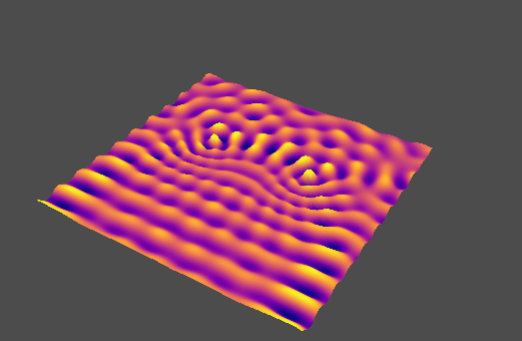!

**Experiment 4** I changed the spread to 5 to change the size of the scattering object. This took way longer to run, so I'm expecting it to be dramatically different.... The code ran, and the entire plot was changed. I think the scattering object was bigger than the entire wave defined, but I couldn't find how to change that. I tried changing plot size, but that just made the actual image bigger. The whole thing looks like an egg crate mattress. The modulus is cool though... attaching image...

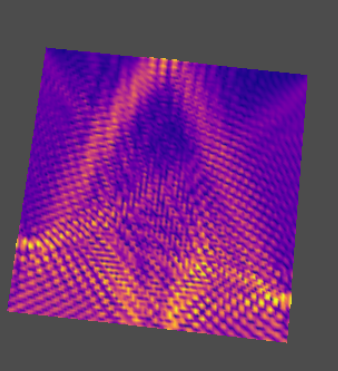

**Experiment 5** I changed the spread to 0.05 to better see the shape of the scattering object. I would like to find a parameter where the full circle shape is visible. sadly, this is not it. The plot was the same as where there was no scattering object.

**Experiment 6** set n_max to 0.02 to make it less refractive than our starting medium. This was actually the closest I've gotten to a circle. In the real results, there are clear waves wrapping around the half-circle shape, then in the i results, there is a tripod looknig shape in the center. Finally, the modulus looks very anatomical (picture att), although I'm realizing I don't really know what the modulus is.

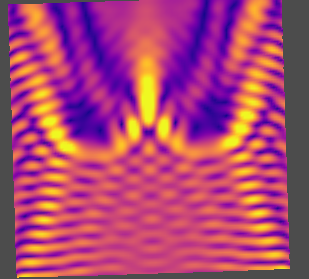

**Experiment 7** Set xc = 1 and yc = 1 to change location of scattering object. This has the exact same effect, just lower on the plot.

## Bonus

Try one of the following, or your own experiments.

- Add one or more additional obstacles to the box.
- Create an obstacle with a sharp boundary instead of a smooth change in index of refraction.

***Describe your efforts and observations below.***

I tried creating a sharp boundary by getting rid of the n_function and leaving the n_max as n of the whole obstacle. This really didn't have an effect, so either I did it wrong, or the boundary doesn't matter, but i find it hard to believe the effect would be the same when the change in n is so sudden. On the other hand, the waves would be the same by the end of the obstacle regardless. 

I created a second obstacle by copying the obstacle code, and setting the first to fill the region starting at XC = -1 and the other starting at XC = 1. this did absolutely nothing, so I set XC for both back to zero, and tried the same for YC. This also did nothing. I think the problem is that I was redefining XC and YC without differentiating between the two, so the second was overwriting the first. So I set the second to YD and XD. Also nothing. I realized after this that I can check my work without running everything by looking at the n plot in the model, but I'm all out of ideas for now.

# Reflection and Summary

- What are the major takeaways of this assignment for you?
 - How drastically the traits of a scattering object affect waves
- What was the most difficult part of this assignment?
 - It was just hard to sort through all the pieces, and I felt like I understood less of the code bits than normal. I didn't know what a lot of it was for or understand the E&M side of it, so it was challening to understand what to do and interpret.
- What was the most interesting part of this assignment?
 - Seeing imaginary values in a real plot
- What questions do you have?
 - What is the modulus?
 - How do you create a second obstacle!
 - is there a value of n, R, or T that would make it possible to have the full shape of teh circle appear in the effect on the wave?>